In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/Groceries_dataset.csv')

In [5]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [6]:
df.itemDescription.value_counts()

whole milk               2502
other vegetables         1898
rolls/buns               1716
soda                     1514
yogurt                   1334
                         ... 
rubbing alcohol             5
bags                        4
baby cosmetics              3
kitchen utensil             1
preservation products       1
Name: itemDescription, Length: 167, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [8]:
df.Date = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


## RFM Analysis

* Recency : 얼마나 최근에 구매했는가
* Frequency : 얼마나 자주 구매했는가
* Monetary : 얼마나 많은 금액을 지출했는가

In [9]:
RFM_df = df.groupby(by = 'Member_number', as_index=False).Date.max()
RFM_df

,Member_number,Date
0,1000,2015-11-25
1,1001,2015-04-14
2,1002,2015-08-30
3,1003,2015-10-02
4,1004,2015-02-12
...,...,...
3893,4996,2015-11-24
3894,4997,2015-12-27
3895,4998,2015-10-14
3896,4999,2015-12-26


In [10]:
r_g = df.groupby(by = 'Member_number', as_index=False).Date.max()

In [11]:
RFM_df['Recency'] = r_g.Date.apply(lambda x: (r_g.Date.max() - x).days)
RFM_df.head()

,Member_number,Date,Recency
0,1000,2015-11-25,35
1,1001,2015-04-14,260
2,1002,2015-08-30,122
3,1003,2015-10-02,89
4,1004,2015-02-12,321


#### visit 

In [12]:
RFM_df['visit'] = df.drop_duplicates(['Date', 'Member_number']).groupby('Member_number', as_index = False).Date.count().Date
RFM_df

,Member_number,Date,Recency,visit
0,1000,2015-11-25,35,5
1,1001,2015-04-14,260,5
2,1002,2015-08-30,122,4
3,1003,2015-10-02,89,4
4,1004,2015-02-12,321,8
...,...,...,...,...
3893,4996,2015-11-24,36,3
3894,4997,2015-12-27,3,2
3895,4998,2015-10-14,77,1
3896,4999,2015-12-26,4,6


#### Monetary

In [13]:
RFM_df['Monetary'] = df.groupby(by = 'Member_number', as_index=False).itemDescription.count().itemDescription


In [14]:
RFM_df = RFM_df.drop('Date', axis = 1)

In [15]:
RFM_df

,Member_number,Recency,visit,Monetary
0,1000,35,5,13
1,1001,260,5,12
2,1002,122,4,8
3,1003,89,4,8
4,1004,321,8,21
...,...,...,...,...
3893,4996,36,3,10
3894,4997,3,2,6
3895,4998,77,1,2
3896,4999,4,6,16


## 군집분석

In [16]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std_RFM_df = std.fit_transform(RFM_df.iloc[:, 1:])
std_RFM_df

array([[-0.93828974,  0.61662016,  0.57534662],
       [ 0.45099882,  0.61662016,  0.38702677],
       [-0.40109816,  0.08567574, -0.36625264],
       ...,
       [-0.67895587, -1.50715751, -1.49617176],
       [-1.12970283,  1.14756458,  1.14030618],
       [-0.60486048, -0.44526868, -0.5545725 ]])

In [87]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import  silhouette_score
TWSS = {}
Dunn = {}
silhouette = {}
for _k in range(2, 11):
    kmeans = KMeans(n_clusters=_k, random_state = 11)
    kmeans.fit(std_RFM_df)
    TWSS[_k] = kmeans.inertia_
    target = kmeans.labels_
    Dunn[_k] = davies_bouldin_score(std_RFM_df, target)
    silhouette[_k] = silhouette_score(std_RFM_df, target)

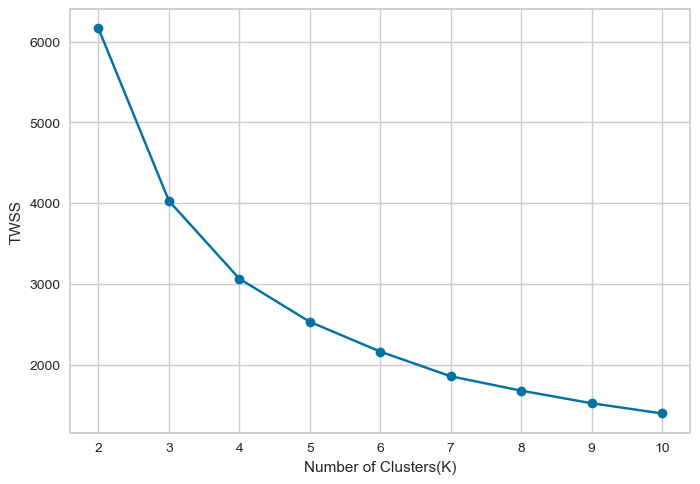

In [88]:
plt.plot(list(TWSS.keys()), list(TWSS.values()), marker= 'o')
plt.xlabel('Number of Clusters(K)')
plt.ylabel('TWSS')
plt.show()

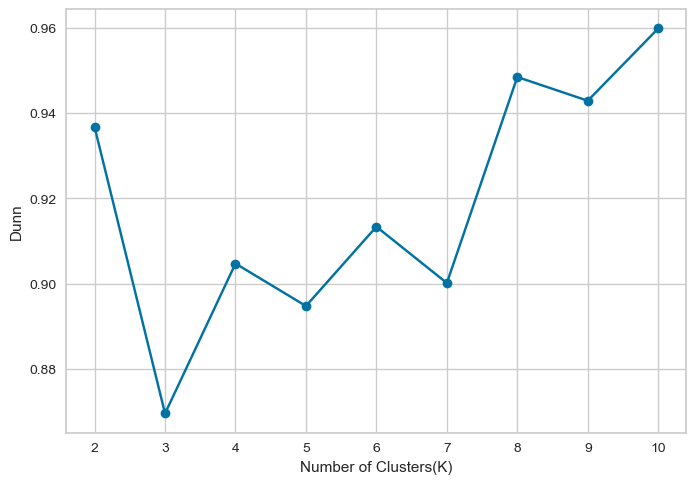

In [89]:
plt.plot(list(Dunn.keys()), list(Dunn.values()), 'bo-')
plt.xlabel('Number of Clusters(K)')
plt.ylabel('Dunn')
plt.show()

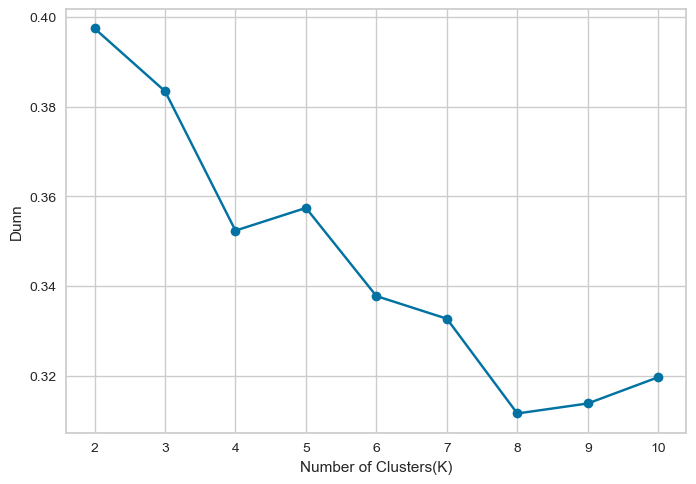

In [90]:
plt.plot(list(silhouette.keys()), list(silhouette.values()), 'bo-')
plt.xlabel('Number of Clusters(K)')
plt.ylabel('Dunn')
plt.show()

In [91]:
_k = 2
kmeans = KMeans(n_clusters=_k, random_state = 11)
kmeans.fit(std_RFM_df)
TWSS[_k] = kmeans.inertia_
target = kmeans.labels_
center = kmeans.cluster_centers_
print(target.reshape(-1, 1))
print(center)

[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
[[ 0.44350566 -0.7102381  -0.70642321]
 [-0.5244591   0.83987842  0.8353672 ]]


In [92]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_score(std_RFM_df, target)

0.39740012052835283

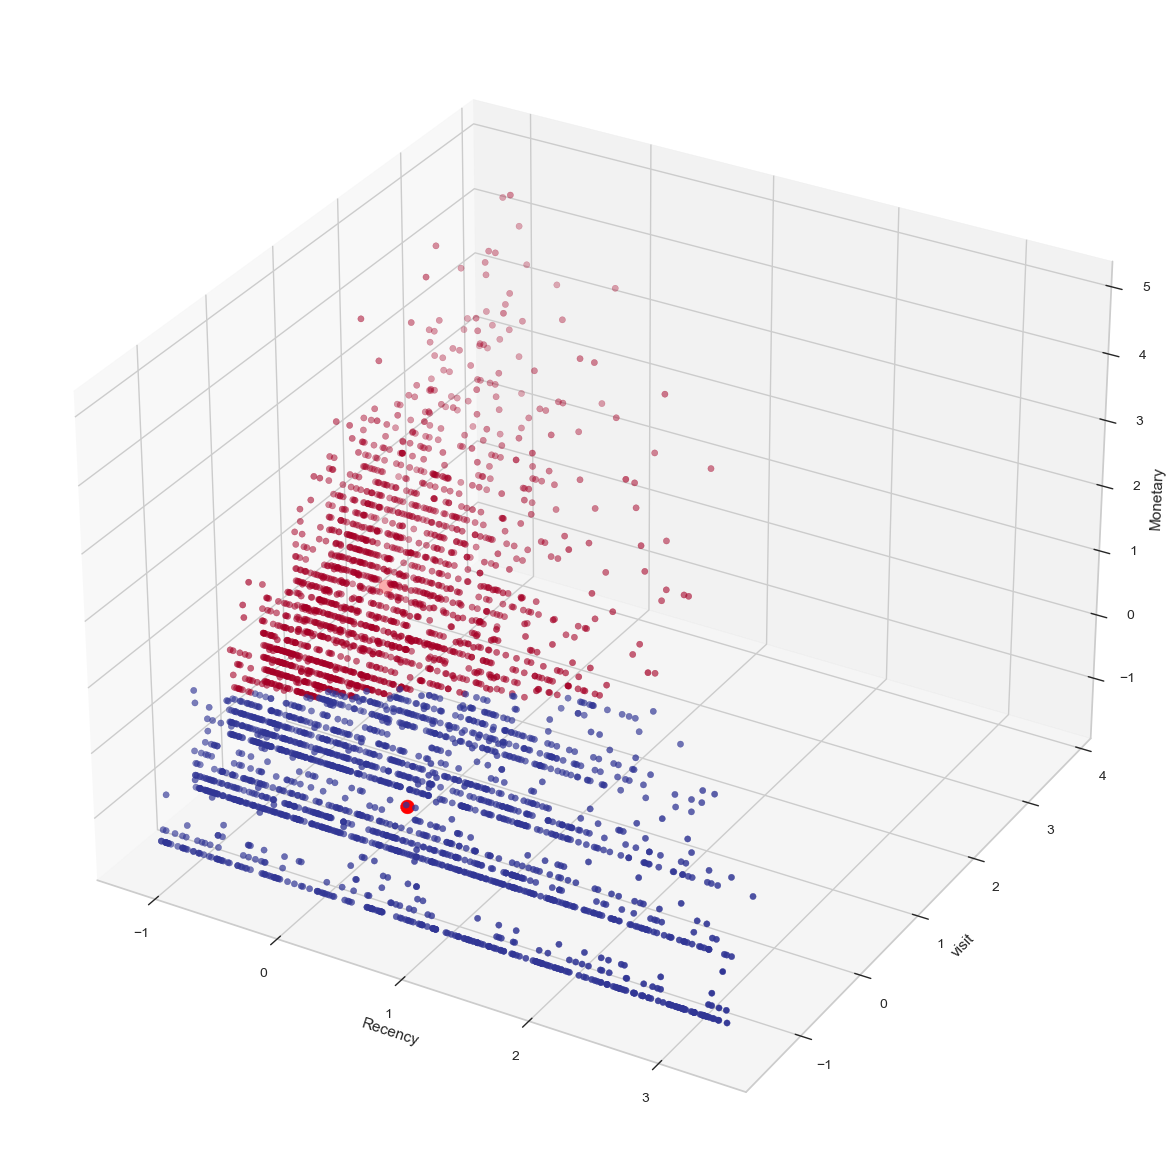

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
ax.scatter(center[:, 0], center[:, 1], center[:, 2], marker='o', s=100, c='red')

ax.scatter(std_RFM_df[:, 0], std_RFM_df[:, 1], std_RFM_df[:, 2], c= target, cmap='RdYlBu_r' )

ax.set_xlabel('Recency')
ax.set_ylabel('visit')
ax.set_zlabel('Monetary')
plt.show()

#### 분류해보기

In [38]:
RFM_df.iloc[:, 1:4]

,Recency,visit,Monetary
0,35,5,13
1,260,5,12
2,122,4,8
3,89,4,8
4,321,8,21
...,...,...,...
3893,36,3,10
3894,3,2,6
3895,77,1,2
3896,4,6,16


In [39]:
from sklearn.model_selection import train_test_split
x_std_tr, x_std_te, y_std_tr, y_std_te = train_test_split(std_RFM_df, target, random_state= 11, stratify= target)
x_std_tr, x_std_val, y_std_tr, y_std_val = train_test_split(std_RFM_df, target, random_state= 11, stratify= target)

In [40]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(RFM_df.iloc[:, 1:4], target, random_state= 11, stratify= target)
x_tr, x_val, y_tr, y_val = train_test_split(RFM_df.iloc[:, 1:4], target, random_state= 11, stratify= target)

In [41]:
target.shape

(3898,)

In [42]:
from pycaret.classification import *

clf = setup(data = x_std_tr, target = y_std_tr)
best_model = compare_models()

,Description,Value
0,Session id,6373
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(2923, 4)"
4,Transformed data shape,"(2923, 4)"
5,Transformed train set shape,"(2046, 4)"
6,Transformed test set shape,"(877, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9966,1.0000,0.9966,0.9966,0.9966,0.9947,0.9947,0.4750
rf,Random Forest Classifier,0.9951,0.9999,0.9951,0.9952,0.9951,0.9924,0.9925,0.1010
et,Extra Trees Classifier,0.9951,0.9999,0.9951,0.9952,0.9951,0.9924,0.9925,0.1030
lightgbm,Light Gradient Boosting Machine,0.9936,0.9999,0.9936,0.9938,0.9936,0.9901,0.9902,0.2040
knn,K Neighbors Classifier,0.9912,0.9987,0.9912,0.9913,0.9912,0.9864,0.9864,0.0140
gbc,Gradient Boosting Classifier,0.9883,0.9998,0.9883,0.9885,0.9882,0.9818,0.9819,0.2250
dt,Decision Tree Classifier,0.9858,0.9890,0.9858,0.9861,0.9858,0.9780,0.9782,0.0110
nb,Naive Bayes,0.9839,0.9997,0.9839,0.9843,0.9839,0.9750,0.9752,0.0100
svm,SVM - Linear Kernel,0.9819,0.0000,0.9819,0.9823,0.9820,0.9720,0.9722,0.0110
lda,Linear Discriminant Analysis,0.9521,0.9971,0.9521,0.9555,0.9521,0.9251,0.9271,0.0110


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

lr = LogisticRegression()
lr.fit(x_std_tr, y_std_tr)
y_pred = lr.predict(x_std_te)

accuracy_score(y_std_te, y_pred)

0.997948717948718

In [44]:
lr2 = LogisticRegression()
lr2.fit(x_tr, y_tr)
y_pred = lr2.predict(x_te)
accuracy_score(y_te, y_pred)

0.9989743589743589

In [45]:
x_te

,Recency,visit,Monetary
1599,38,4,16
3803,566,1,2
2346,68,4,13
1320,117,5,13
2761,591,2,5
...,...,...,...
1967,155,3,9
2925,596,1,4
2712,199,3,9
3412,137,2,6


In [46]:
lr2.predict([[40,5,10]])

array([1])

In [47]:
custrom_class = lr2.predict([[40,5,10]])
if custrom_class == 0: grade = '이탈 가능 고객'
elif custrom_class == 1: grade = '일반 고객'
elif custrom_class == 2: grade = '우수 고객'
result = f"{grade}입니다."
result

'일반 고객입니다.'

In [48]:
import joblib
joblib.dump(lr, 'std_customerClass.pkl')
joblib.dump(lr2, 'not_customerClass.pkl')


['not_customerClass.pkl']

## 연관분석하기

In [49]:
df.sort_values('Member_number')

,Member_number,Date,itemDescription
1629,1000,2015-05-27,soda
13331,1000,2014-06-24,whole milk
8395,1000,2015-03-15,whole milk
4843,1000,2015-03-15,sausage
17778,1000,2015-05-27,pickled vegetables
...,...,...,...
34885,5000,2015-10-02,semi-finished bread
25489,5000,2014-11-16,other vegetables
9340,5000,2014-11-16,bottled beer
27877,5000,2014-09-03,onions


In [50]:
RFM_df['class'] = target
RFM_df.head()

,Member_number,Recency,visit,Monetary,class
0,1000,35,5,13,0
1,1001,260,5,12,0
2,1002,122,4,8,1
3,1003,89,4,8,1
4,1004,321,8,21,0


In [51]:
purchase_df = pd.merge(df, RFM_df, how='inner', on = 'Member_number')
purchase_df = purchase_df.sort_values('Member_number')
purchase_df = purchase_df.drop(['Recency', 'visit', 'Monetary'], axis = 1)
purchase_df = purchase_df[(purchase_df['class'] == 1) | (purchase_df['class'] == 2)]
purchase_df

,Member_number,Date,itemDescription,class
29927,1002,2014-09-02,other vegetables,1
29922,1002,2014-04-26,butter,1
29923,1002,2014-09-02,frozen vegetables,1
29924,1002,2015-04-26,sugar,1
29925,1002,2015-08-30,specialty chocolate,1
...,...,...,...,...
27084,5000,2014-11-16,other vegetables,1
27083,5000,2015-10-02,root vegetables,1
27082,5000,2014-09-03,fruit/vegetable juice,1
27081,5000,2014-11-16,bottled beer,1


In [52]:
items = purchase_df.itemDescription.unique()
len(items)

166

In [53]:
df2 = purchase_df.drop(columns='Date')

In [54]:
df2['num'] = 1

In [55]:
g_df = df2.groupby(['Member_number', 'itemDescription']).num.count()
g_df

Member_number  itemDescription    
1002           butter                 1
               butter milk            1
               frozen vegetables      1
               other vegetables       1
               specialty chocolate    1
                                     ..
5000           onions                 1
               other vegetables       1
               root vegetables        1
               semi-finished bread    1
               soda                   1
Name: num, Length: 17210, dtype: int64

In [56]:
stack_df = g_df.unstack()
stack_df

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN
1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN


In [57]:
saler_df = stack_df.applymap(lambda x: 1 if x >= 1 else 0)
saler_df = saler_df.astype(bool)

In [58]:
freq = saler_df.sum(axis = 0).to_frame('Frequency')
freq_sort = freq.sort_values('Frequency', ascending=False)
freq_sort

,Frequency
itemDescription,
whole milk,947
other vegetables,754
rolls/buns,714
soda,639
yogurt,557
...,...
salad dressing,2
whisky,2
baby cosmetics,2


In [60]:
freq_sort['Support'] = freq_sort['Frequency']/len(freq_sort)
freq_sort

,Frequency,Support
itemDescription,,
whole milk,947,5.704819
other vegetables,754,4.542169
rolls/buns,714,4.301205
soda,639,3.849398
yogurt,557,3.355422
...,...,...
salad dressing,2,0.012048
whisky,2,0.012048
baby cosmetics,2,0.012048


In [61]:
freq_items = apriori(saler_df, min_support = 0.05, use_colnames=True)
freq_items

,support,itemsets
0,0.054455,(UHT-milk)
1,0.086443,(beef)
2,0.057883,(berries)
3,0.115004,(bottled beer)
4,0.161843,(bottled water)
5,0.099010,(brown bread)
6,0.090632,(butter)
7,0.116908,(canned beer)
8,0.068545,(chicken)
9,0.058264,(chocolate)


In [62]:
num = [i for i in freq_items.itemsets if len(i) == 1]
num[1]

frozenset({'beef'})

In [63]:
rules = association_rules(freq_items, metric='lift', min_threshold=1)
rules = rules.sort_values('confidence', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bottled water),(whole milk),0.161843,0.360625,0.063595,0.392941,1.089613,0.005230,1.053235
18,(tropical fruit),(whole milk),0.175933,0.360625,0.068165,0.387446,1.074375,0.004719,1.043786
11,(rolls/buns),(whole milk),0.271896,0.360625,0.103199,0.379552,1.052485,0.005146,1.030506
14,(sausage),(whole milk),0.143564,0.360625,0.054075,0.376658,1.044460,0.002302,1.025722
20,(yogurt),(whole milk),0.212110,0.360625,0.079589,0.375224,1.040485,0.003097,1.023368
6,(other vegetables),(whole milk),0.287129,0.360625,0.105484,0.367374,1.018716,0.001938,1.010669
2,(citrus fruit),(whole milk),0.145088,0.360625,0.052551,0.362205,1.004382,0.000229,1.002478
5,(root vegetables),(other vegetables),0.174410,0.287129,0.051028,0.292576,1.018973,0.000950,1.007701
7,(whole milk),(other vegetables),0.360625,0.287129,0.105484,0.292503,1.018716,0.001938,1.007596
10,(whole milk),(rolls/buns),0.360625,0.271896,0.103199,0.286167,1.052485,0.005146,1.019991


In [64]:
rules.to_csv('rules2.csv')
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bottled water),(whole milk),0.161843,0.360625,0.063595,0.392941,1.089613,0.005230,1.053235
18,(tropical fruit),(whole milk),0.175933,0.360625,0.068165,0.387446,1.074375,0.004719,1.043786
11,(rolls/buns),(whole milk),0.271896,0.360625,0.103199,0.379552,1.052485,0.005146,1.030506
14,(sausage),(whole milk),0.143564,0.360625,0.054075,0.376658,1.044460,0.002302,1.025722
20,(yogurt),(whole milk),0.212110,0.360625,0.079589,0.375224,1.040485,0.003097,1.023368
6,(other vegetables),(whole milk),0.287129,0.360625,0.105484,0.367374,1.018716,0.001938,1.010669
2,(citrus fruit),(whole milk),0.145088,0.360625,0.052551,0.362205,1.004382,0.000229,1.002478
5,(root vegetables),(other vegetables),0.174410,0.287129,0.051028,0.292576,1.018973,0.000950,1.007701
7,(whole milk),(other vegetables),0.360625,0.287129,0.105484,0.292503,1.018716,0.001938,1.007596
10,(whole milk),(rolls/buns),0.360625,0.271896,0.103199,0.286167,1.052485,0.005146,1.019991


In [65]:
set(list(rules.consequents))

{frozenset({'rolls/buns'}),
 frozenset({'whole milk'}),
 frozenset({'bottled water'}),
 frozenset({'tropical fruit'}),
 frozenset({'sausage'}),
 frozenset({'other vegetables'}),
 frozenset({'yogurt'}),
 frozenset({'citrus fruit'}),
 frozenset({'soda'}),
 frozenset({'root vegetables'})}

In [66]:
def Search(item1):
    global rules
    for i in set(rules.antecedents):
        if list(i) == [item1]:
            dfdf = rules[rules.antecedents == i].sort_values('confidence')
            if len(dfdf) > 5:
                return [list(dfdf.iloc[j, 1]) for j in range(5)]
            elif len(dfdf) > 0:
                for n in range(len(dfdf)):
                    return [list(dfdf.iloc[_, 1]) for _ in range(len(dfdf))]
            else:
                return '연관된 상품이 없습니다.'
    else:
        return '연관된 상품이 없습니다.'

In [67]:
Search('other vegetables')

[['root vegetables'], ['whole milk']]

In [68]:
Search('whole milk')

[['citrus fruit'],
 ['sausage'],
 ['bottled water'],
 ['tropical fruit'],
 ['yogurt']]